# $1^{st}$ fine tuning

In [1]:
!nvidia-smi

Sun Apr  4 00:37:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null

In [3]:
!pip install --upgrade grpcio >> /dev/null

ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.36.1 which is incompatible.
ERROR: tensorflow-gpu 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.36.1 which is incompatible.


In [4]:
!pip install hyperas

In [5]:
!pip install tqdm  >> /dev/null

In [6]:
!pip install bert-for-tf2 >> /dev/null

In [7]:
!pip install sentencepiece >> /dev/null

In [8]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data

In [9]:
askubuntu_train = pd.read_csv("askubuntu_train.csv")
askubuntu_valid = pd.read_csv("askubuntu_val.csv")
askubuntu_test = pd.read_csv("askubuntu_test.csv")

askubuntu_train = askubuntu_train.append(askubuntu_valid).reset_index(drop=True)

In [10]:
webapps_train = pd.read_csv("webapps_train.csv")
webapps_valid = pd.read_csv("webapps_val.csv")
webapps_test = pd.read_csv("webapps_test.csv")

webapps_train = webapps_train.append(webapps_valid).reset_index(drop=True)

In [11]:
chatbot_train = pd.read_csv("chatbot_train.csv")
chatbot_valid = pd.read_csv("chatbot_val.csv")
chatbot_test = pd.read_csv("chatbot_test.csv")

chatbot_train = chatbot_train.append(chatbot_valid).reset_index(drop=True)

In [12]:
print(askubuntu_train.shape)
print(webapps_train.shape)
print(chatbot_train.shape)

(53, 2)
(30, 2)
(100, 2)


In [13]:
askubuntu_train.head()

,text,intent
0,Upgrade to 12.04 64 bit,0
1,How To Install Canon LBP2900B printer in 14.04...,2
2,Shutdown after a certain time,3
3,Password Management Applications?,4
4,How to shutdown computer when users are logged...,3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


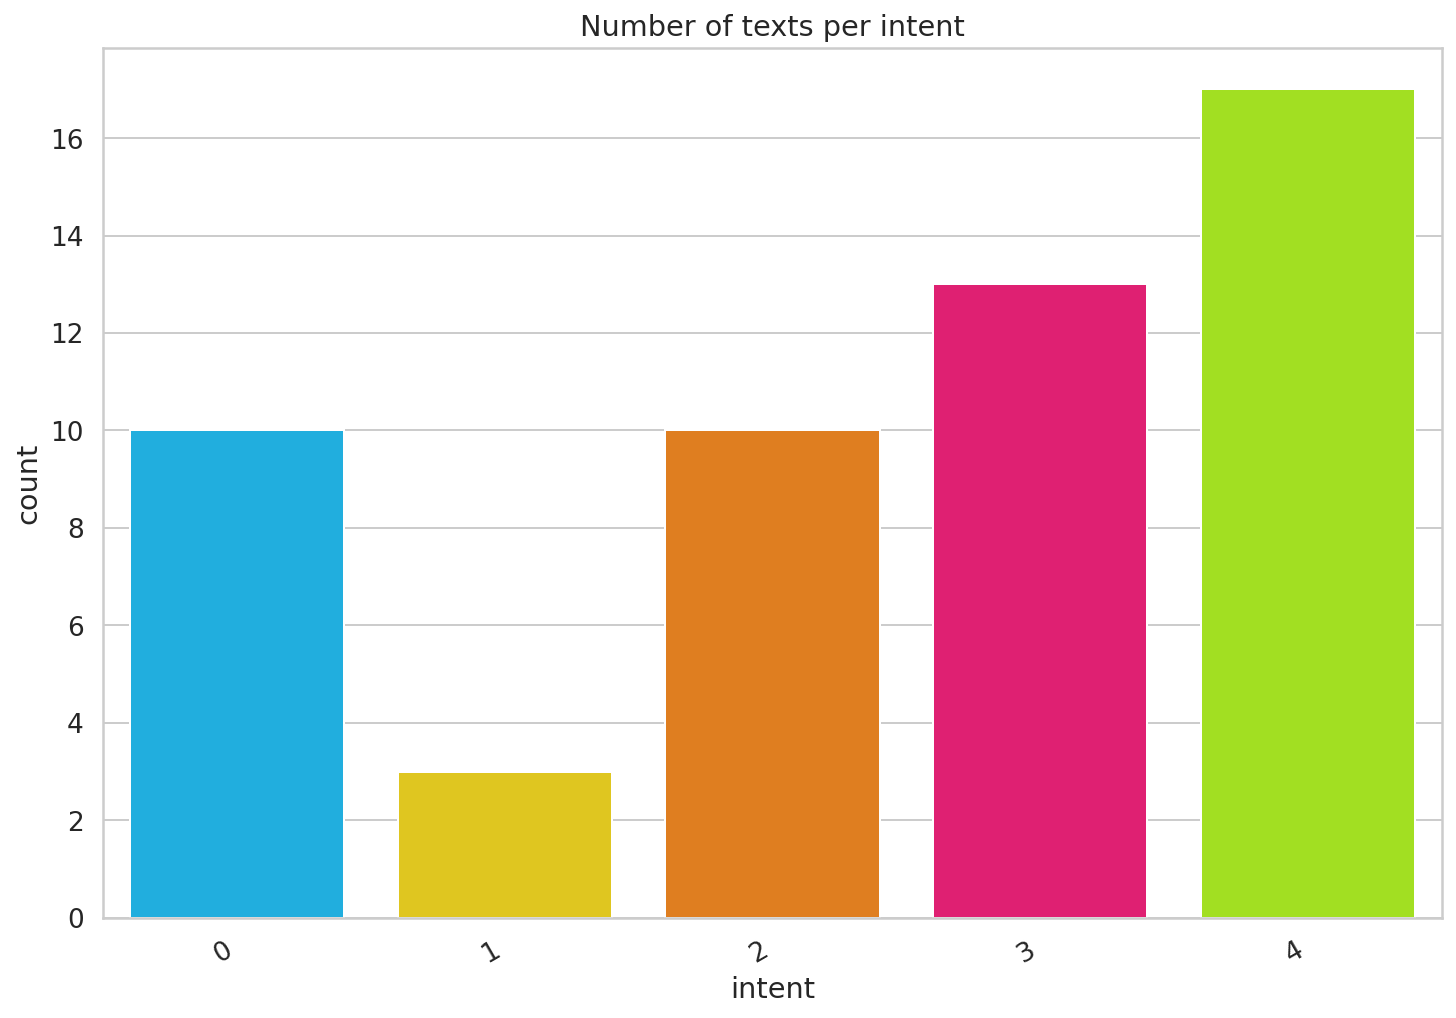

In [14]:
chart = sns.countplot(askubuntu_train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


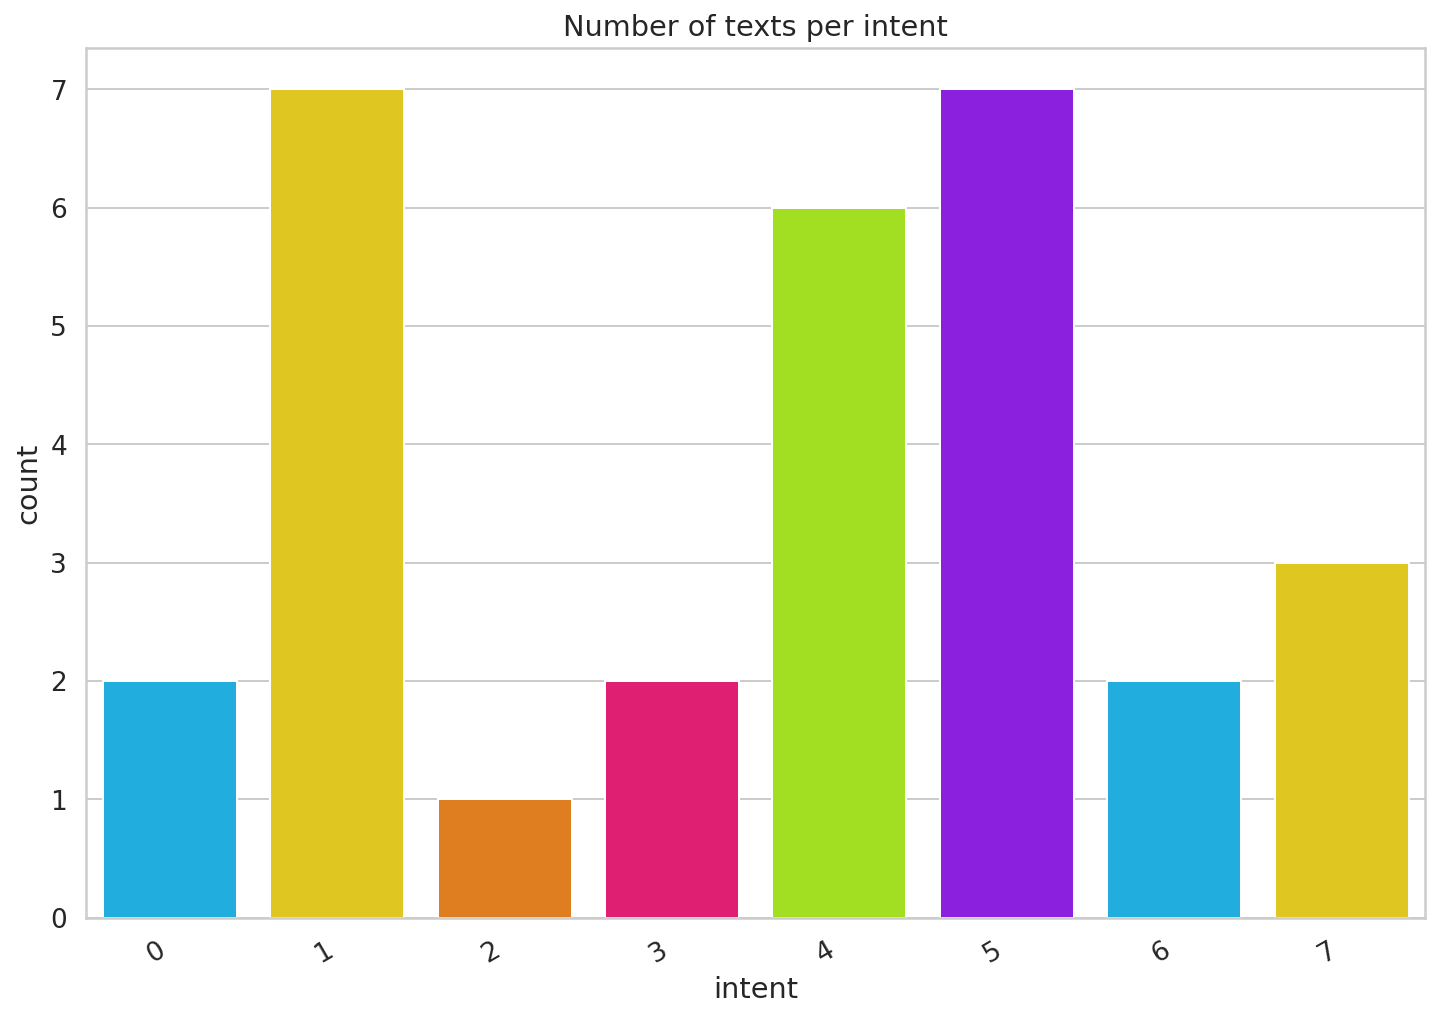

In [15]:
chart = sns.countplot(webapps_train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


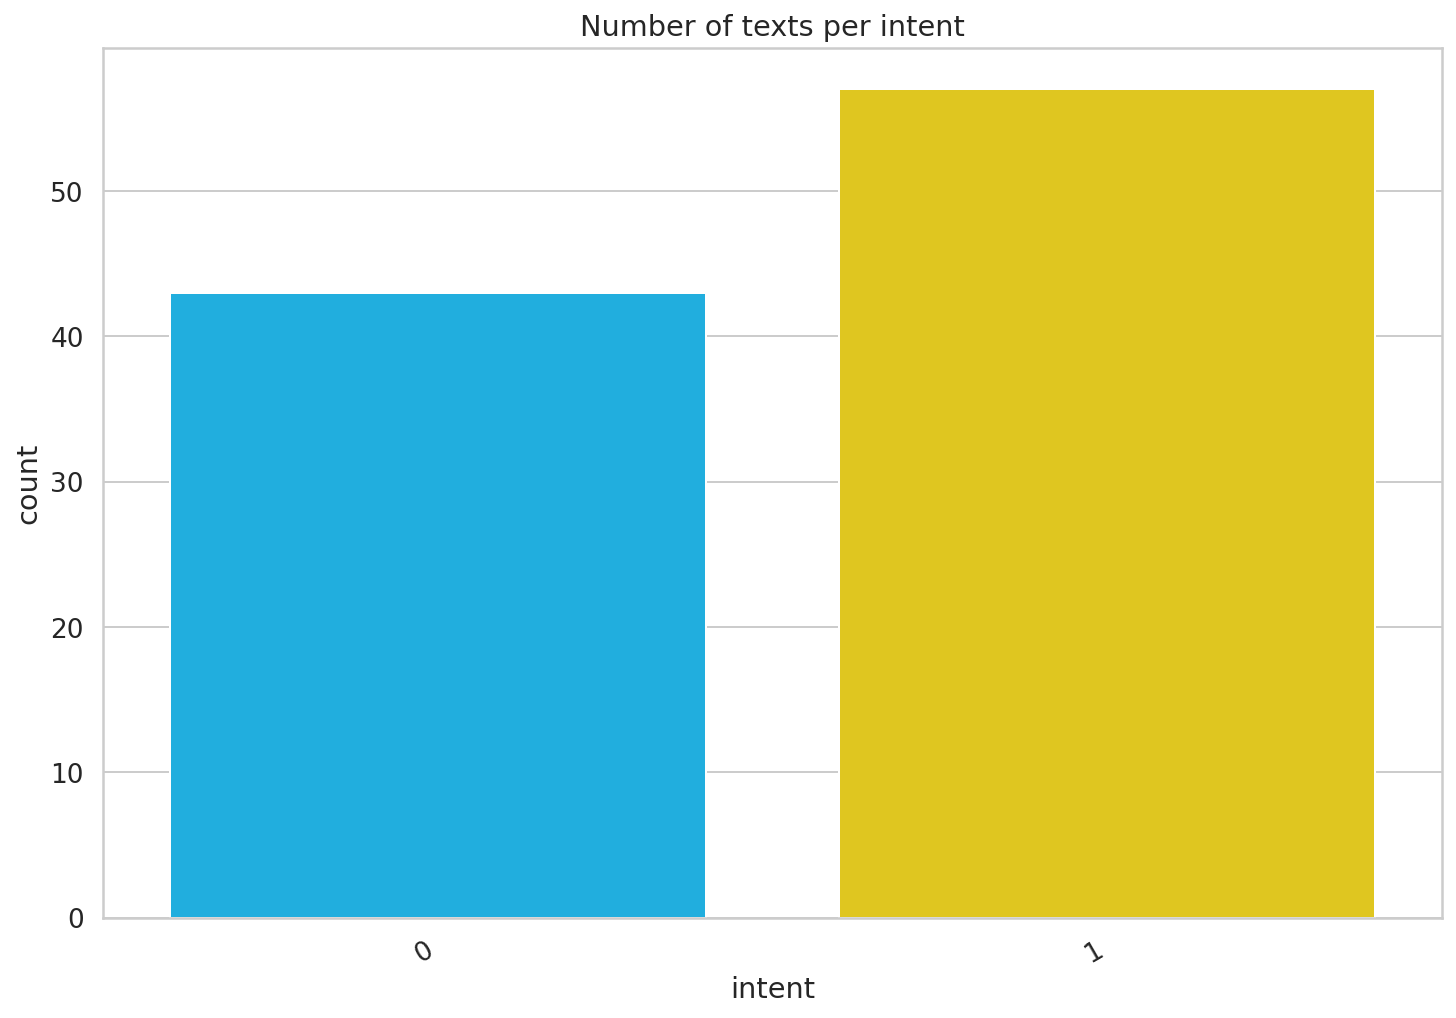

In [16]:
chart = sns.countplot(chatbot_train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Intent Recognition with BERT

In [17]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-04-04 00:38:38--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.15.112, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   116MB/s    in 3.4s    

2021-04-04 00:38:42 (116 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [18]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [19]:
os.makedirs("model", exist_ok=True)

In [20]:
!mv uncased_L-12_H-768_A-12/ model

In [21]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [22]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      #print(label)
      y.append(label)

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [23]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [24]:
def create_model(max_seq_len, bert_ckpt_file, classes):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [25]:
askubuntu_classes = askubuntu_train.intent.unique().tolist()

askubuntu_data = IntentDetectionData(askubuntu_train, askubuntu_test, tokenizer, askubuntu_classes, max_seq_len=128)

webapps_classes = webapps_train.intent.unique().tolist()

webapps_data = IntentDetectionData(webapps_train, webapps_test, tokenizer, webapps_classes, max_seq_len=128)

chatbot_classes = chatbot_train.intent.unique().tolist()

chatbot_data = IntentDetectionData(chatbot_train, chatbot_test, tokenizer, chatbot_classes, max_seq_len=128)

53it [00:00, 581.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
109it [00:00, 3177.94it/s]
30it [00:00, 2799.00it/s]
59it [00:00, 2015.44it/s]
100it [00:00, 2725.27it/s]
106it [00:00, 3561.87it/s]

max seq_len 33
max seq_len 28
max seq_len 31


In [26]:
askubuntu_model = create_model(askubuntu_data.max_seq_len, bert_ckpt_file, askubuntu_train.intent.unique().tolist())
webapps_model = create_model(webapps_data.max_seq_len, bert_ckpt_file, webapps_train.intent.unique().tolist())
chatbot_model = create_model(chatbot_data.max_seq_len, bert_ckpt_file, chatbot_train.intent.unique().tolist())

bert shape (None, 33, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6dc8f3cd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
bert shape (None, 28, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6dc891d50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/tok

In [27]:
askubuntu_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 33)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 33, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3845  

In [28]:
webapps_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 28, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 6152

In [29]:
chatbot_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 31)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 31, 768)           108890112 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1538

In [30]:
askubuntu_model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

webapps_model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

chatbot_model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

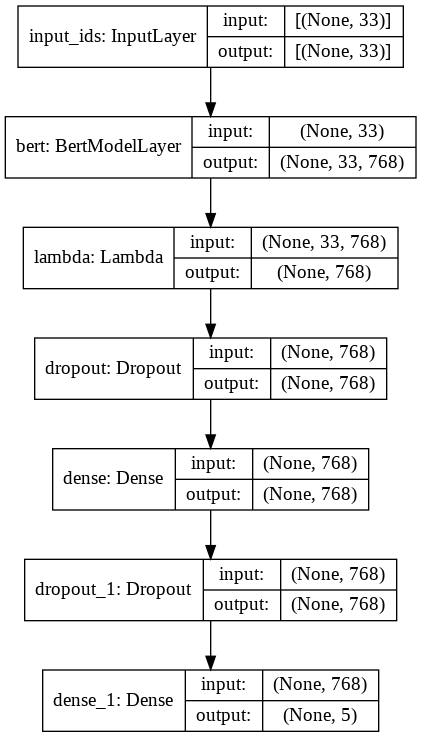

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(askubuntu_model, to_file='askubuntu_model.png', show_shapes=True, show_layer_names=True)

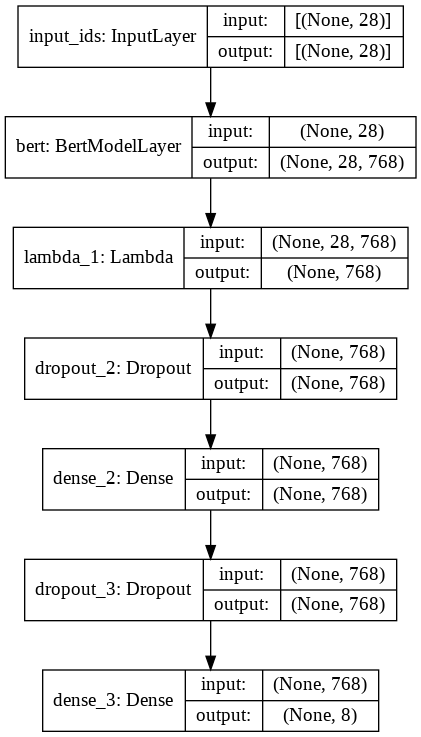

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(webapps_model, to_file='webapps_model.png', show_shapes=True, show_layer_names=True)

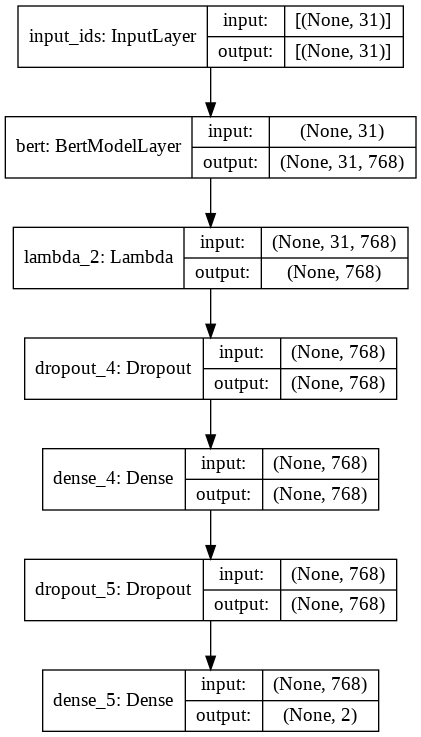

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(chatbot_model, to_file='chatbot_model.png', show_shapes=True, show_layer_names=True)

In [34]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = askubuntu_model.fit(
  x=askubuntu_data.train_x, 
  y=askubuntu_data.train_y,
  validation_split=0.2,
  batch_size=3,
  shuffle=False,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
14/14 [==============================] - 20s 583ms/step - loss: 2.0342 - acc: 0.1078 - val_loss: 1.3646 - val_acc: 0.1818
Epoch 2/5
14/14 [==============================] - 3s 242ms/step - loss: 1.6376 - acc: 0.2208 - val_loss: 1.2854 - val_acc: 0.4545
Epoch 3/5
14/14 [==============================] - 4s 252ms/step - loss: 1.6601 - acc: 0.2808 - val_loss: 1.2575 - val_acc: 0.5455
Epoch 4/5
14/14 [==============================] - 3s 251ms/step - loss: 1.4038 - acc: 0.3557 - val_loss: 1.1436 - val_acc: 0.7273
Epoch 5/5
14/14 [==============================] - 3s 249ms/step - loss: 1.1498 - acc: 0.6180 - val_loss: 1.0089 - val_acc: 0.8182


In [35]:
loss, accuracy = askubuntu_model.evaluate(askubuntu_data.test_x, askubuntu_data.test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 0s 91ms/step - loss: 1.1966 - acc: 0.6239
Loss: 1.196578860282898
Accuracy: 0.6238532066345215


In [36]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = webapps_model.fit(
  x=webapps_data.train_x, 
  y=webapps_data.train_y,
  validation_split=0.2,
  batch_size=1,
  shuffle=False,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
24/24 [==============================] - 18s 383ms/step - loss: 2.4928 - acc: 0.0437 - val_loss: 2.2078 - val_acc: 0.0000e+00
Epoch 2/5
24/24 [==============================] - 6s 239ms/step - loss: 1.6621 - acc: 0.3754 - val_loss: 2.0925 - val_acc: 0.1667
Epoch 3/5
24/24 [==============================] - 6s 238ms/step - loss: 1.9727 - acc: 0.3765 - val_loss: 1.7924 - val_acc: 0.1667
Epoch 4/5
24/24 [==============================] - 6s 240ms/step - loss: 1.6430 - acc: 0.5197 - val_loss: 2.3338 - val_acc: 0.1667
Epoch 5/5
24/24 [==============================] - 6s 236ms/step - loss: 1.3430 - acc: 0.4887 - val_loss: 2.2233 - val_acc: 0.1667


In [37]:
loss, accuracy = webapps_model.evaluate(webapps_data.test_x, webapps_data.test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2/2 [==============================] - 3s 112ms/step - loss: 2.0489 - acc: 0.2203
Loss: 2.048888921737671
Accuracy: 0.22033898532390594


In [38]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = chatbot_model.fit(
  x=chatbot_data.train_x, 
  y=chatbot_data.train_y,
  validation_split=0.2,
  batch_size=3,
  shuffle=False,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
27/27 [==============================] - 27s 498ms/step - loss: 0.7647 - acc: 0.5935 - val_loss: 0.6400 - val_acc: 0.4500
Epoch 2/5
27/27 [==============================] - 8s 293ms/step - loss: 0.7763 - acc: 0.5240 - val_loss: 0.3743 - val_acc: 0.9000
Epoch 3/5
27/27 [==============================] - 8s 294ms/step - loss: 0.5724 - acc: 0.6456 - val_loss: 0.2410 - val_acc: 0.9500
Epoch 4/5
27/27 [==============================] - 8s 290ms/step - loss: 0.2536 - acc: 0.9089 - val_loss: 0.2118 - val_acc: 0.9500
Epoch 5/5
27/27 [==============================] - 8s 290ms/step - loss: 0.1549 - acc: 0.9207 - val_loss: 0.3541 - val_acc: 0.9500


In [39]:
loss, accuracy = chatbot_model.evaluate(chatbot_data.test_x, chatbot_data.test_y)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 0s 88ms/step - loss: 0.1614 - acc: 0.9434
Loss: 0.16144585609436035
Accuracy: 0.9433962106704712


## Evaluation

In [46]:
_, train_acc = chatbot_model.evaluate(chatbot_data.train_x, chatbot_data.train_y)
_, test_acc = chatbot_model.evaluate(chatbot_data.test_x, chatbot_data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

4/4 [==============================] - 0s 69ms/step - loss: 0.1614 - acc: 0.9434
train acc 0.9800000190734863
test acc 0.9433962106704712


In [47]:
_, train_acc = webapps_model.evaluate(webapps_data.train_x, webapps_data.train_y)
_, test_acc = webapps_model.evaluate(webapps_data.test_x, webapps_data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

2/2 [==============================] - 0s 82ms/step - loss: 2.0489 - acc: 0.2203
train acc 0.4333333373069763
test acc 0.22033898532390594


In [48]:
_, train_acc = askubuntu_model.evaluate(askubuntu_data.train_x, askubuntu_data.train_y)
_, test_acc = askubuntu_model.evaluate(askubuntu_data.test_x, askubuntu_data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

4/4 [==============================] - 0s 76ms/step - loss: 1.1966 - acc: 0.6239
train acc 0.849056601524353
test acc 0.6238532066345215
